In [9]:
import numpy as np
import numpy.linalg as LA
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [10]:
# nearPD(A) calc projection of A to pd
import numpy as np

def _getAplus(A):
    eigval, eigvec = np.linalg.eig(A)
    Q = np.matrix(eigvec)
    xdiag = np.matrix(np.diag(np.maximum(eigval, 0)))
    return Q*xdiag*Q.T

def _getPs(A, W=None):
    W05 = np.matrix(W**.5)
    return  W05.I * _getAplus(W05 * A * W05) * W05.I

def _getPu(A, W=None):
    Aret = np.array(A.copy())
    Aret[W > 0] = np.array(W)[W > 0]
    return np.matrix(Aret)

def nearPD(A, nit=10):
    n = A.shape[0]
    W = np.identity(n) 
# W is the matrix used for the norm (assumed to be identity matrix here)
# the algorithm should work for any diagonal W
    deltaS = 0
    Yk = A.copy()
    for k in range(nit):
        Rk = Yk - deltaS
        Xk = _getPs(Rk, W=W)
        deltaS = Xk - Rk
        Yk = _getPu(Xk, W=W)
    return np.array(Yk)

In [11]:
n = 1000
m = 3*n
eps = 0.1
data_dim = 2
mu = 0
mu_out = 6
par_mu = np.full(data_dim, mu)
# par_sd = np.identity(data_dim)
out_mu = np.full(data_dim, mu_out)

par_reg1=0.005
exper_iter = 10
optim_iter = 400
L = 1
learn_par = 0.0005
dicay_par = 0.5

def sigmoid(x):
    return 1/(np.exp(-x) + 1)

def deriv_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def g_up(t, s):
    return sigmoid(s) + deriv_sigmoid(s)*(t-s) + (t-s)**2/20

def g_lo(t, s):
    return sigmoid(s) + deriv_sigmoid(s)*(t-s) - (t-s)**2/20



def create_out_cov(data_dim):
    return_cov = np.zeros([data_dim, data_dim])
    for i in range(data_dim):
        for j in range(i+1):
            z = np.random.uniform(0.4, 0.8)
            gamma = np.random.binomial(n = 1,p=0.1)
            return_cov[i][j] = z*gamma
            return_cov[j][i] = z*gamma
    return_cov = return_cov +(np.abs(np.linalg.eig(return_cov)[0]) +0.05)*np.identity(data_dim)
    return return_cov

In [12]:
# 分散を固定しない
par_cov = np.eye(data_dim)
out_cov = np.eye(data_dim)
true_alpha = [par_mu, par_cov]
res_mu = [0 for i in range(exper_iter)]
res_cov = [0 for i in range(exper_iter)]
for i in range(exper_iter):
    print("%d/%d" %(i+1, exper_iter))
    data = np.random.multivariate_normal(mean = par_mu, cov = par_cov, size = int(n*(1-eps)))
    # Gaoの論文の設定
    contamination = np.random.multivariate_normal(mean = out_mu, cov = out_cov, size = (n - int(n*(1-eps))))
    data = np.concatenate([data, contamination])
    np.random.shuffle(data)
    alpha_hist = []
    cov_hist = []
    # 平均は次元ごとにロバスト、分散はロバストでない
    alpha = [np.median(data, axis=0), np.cov(data, rowvar = False)]
    par = np.random.normal(scale = 0.1, size = 2*data_dim + 1)
    for j in tqdm(range(1, optim_iter+1)):
        z = np.random.multivariate_normal(mean=alpha[0], cov=alpha[1], size = m)
        def major_func(par, past_par):
            new_beta = par[0:2*data_dim]; new_b = par[2*data_dim]; beta = past_par[0:2*data_dim]; b = past_par[2*data_dim]
            A = np.mean(g_lo(np.dot(np.stack([z, z**2], axis=1).reshape(m, 2*data_dim),new_beta) - new_b, np.dot(np.stack([z, z**2], axis=1).reshape(m, 2*data_dim),beta) - b))
            B = np.mean(g_up(np.dot(np.stack([data, data**2], axis=1).reshape(n, 2*data_dim),new_beta) - new_b, np.dot(np.stack([data, data**2], axis=1).reshape(n, 2*data_dim),beta) - b))
            reg = np.linalg.norm(new_beta, ord=2)*par_reg1
            return -(A-B -reg)
        
        l = 0
        while(l<L):
            op = minimize(major_func, x0 = np.zeros(2*data_dim +1), args = par)
            par = op.x
            l+=1
        
        alpha_m = alpha[0]; alpha_v = alpha[1]
        v_inv = np.linalg.inv(alpha_v)
        mgrad = (v_inv*(z-alpha_m)[:, np.newaxis, :]).sum(axis=2)
        sigma_grad = (alpha_v - (z- alpha_m)[:,:,np.newaxis] * (z-alpha_m)[:, np.newaxis, :])/2
        sig_ = sigmoid(np.dot(np.stack([z, z**2], axis=1).reshape(m, 2*data_dim),par[0:2*data_dim ])- par[2*data_dim])[:,np.newaxis]
        tmp_alpha_m = alpha[0] - learn_par/j**dicay_par * np.mean(mgrad*sig_, axis = 0)
        tmp_alpha_v = v_inv - learn_par/j**dicay_par * np.mean(sigma_grad*sig_[:,:,np.newaxis], axis = 0)
        # hegman 2000
        #projection_alpha_v = nearPD(tmp_alpha_v)
        
        # # SVD
        # eig_val, eig_vec = np.linalg.eig(tmp_alpha_v)
        # np.max(np.concatenate([eig_val[:, np.newaxis], np.full(len(eig_val), 0.001)[:, np.newaxis]], axis = 1), axis = 1)
        # tmp_alpha_v = 

        alpha[0], alpha[1] = tmp_alpha_m, (LA.inv(tmp_alpha_v))
        alpha_hist.append(alpha[0])
        cov_hist.append(alpha[1])
    res_mu[i] = alpha_hist
    res_cov[i] =  cov_hist



1/10


ModuleNotFoundError: No module named 'numpy.dual'

In [7]:
def calc_op_norm(cov):
    return np.max(np.linalg.eig(cov)[0])

    
def calc_f_norm(cov):
    return np.sum(cov**2)

# for 1 exper_iter
def result_plot(res):
    mean = np.array(res[0][0])
    for i in range(optim_iter):
        l2_norm_mu = np.linalg.norm(mean[i], ord = 2)
        plt.scatter(i, l2_norm_mu)
    plt.subplots()
    cov = np.array(res[0][1])
    for i in range(optim_iter):
        op_norm = np.abs(calc_op_norm(cov[i] - np.eye(data_dim)))
        plt.scatter(i, op_norm)
    plt.subplots()
    for i in range(optim_iter):
        f_norm = np.abs(calc_f_norm(cov[i] - np.eye(data_dim)))
        plt.scatter(i, f_norm)

# 分散　正定値にしない
mu
- mean: 0.55025
- std : 0.25188

op_norm
- mean:4.90425
- std :1.48638

# Higham (2000)
mu
- mean:0.54750
- std :0.30382

op norm
- mean:1.25215
- std :0.22176

# SP norm による射影


mean:0.18835
std :0.05253
mean:1.47747
std :0.05885


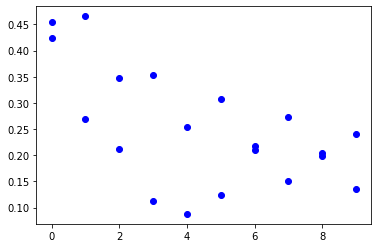

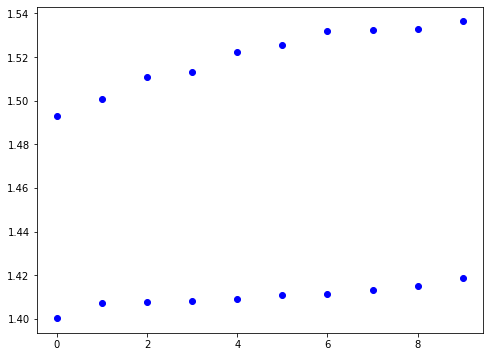

In [14]:
#-gm p = 10
sum = []
for i in range(exper_iter):
    mu = np.array(res_mu[i])
    for j in range(optim_iter):
        l2_norm = np.linalg.norm(mu[j], ord=2)
        plt.scatter(j, l2_norm, color = "blue")
    sum.append(l2_norm)

print("mean:%.5f"%(np.mean(sum)))
print("std :%.5f"%(np.std(sum)))
sum = []
plt.figure(figsize=(8, 6))
for i in range(exper_iter):
    cov = np.array(res_cov[i])
    colorlist = ["r", "g", "b", "c", "m", "y", "k", "#984ea3",'#e41a1c', '#377eb8']
    for j in range(optim_iter):
        op_norm = np.abs(calc_op_norm(cov[j] -par_cov))
        plt.scatter(j, op_norm, color = "blue")
    sum.append(op_norm)
print("mean:%.5f"%(np.mean(sum)))
print("std :%.5f"%(np.std(sum)))